# Linear Interpolation

In [2]:
import tensorflow as tf
import numpy as np
from logistic.multilayer_perceptron import inference, loss

import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
# mnist data image of shape 28*28=784
x = tf.placeholder("float", [None, 784])
# 0-9 digits recognition => 10 classes
y = tf.placeholder("float", [None, 10]) 

In [4]:
sess = tf.Session()

In [5]:
with tf.variable_scope("mlp_model") as scope:
    output_opt = inference(x)
    cost_opt = loss(output_opt, y)
    saver = tf.train.Saver()
    scope.reuse_variables()
    var_list_opt = [
        "hidden_1/W",
        "hidden_1/b",
        "hidden_2/W",
        "hidden_2/b",
        "output/W",
        "output/b"
    ]
    var_list_opt = [tf.get_variable(v) for v in var_list_opt]
    saver.restore(sess, 'mlp_logs\model-checkpoint-9009')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

INFO:tensorflow:Restoring parameters from mlp_logs\model-checkpoint-9009


In [6]:
with tf.variable_scope("mlp_init") as scope:
    output_rand = inference(x)
    cost_rand = loss(output_rand, y)
    scope.reuse_variables()
    var_list_rand = [
        "hidden_1/W",
        "hidden_1/b",
        "hidden_2/W",
        "hidden_2/b",
        "output/W",
        "output/b"
    ]
    var_list_rand = [tf.get_variable(v) for v in var_list_rand]
    init_op = tf.initializers.variables(var_list_rand)
    sess.run(init_op)

In [7]:
with tf.variable_scope("mlp_inter") as scope:

    alpha = tf.placeholder("float", [1, 1])
    beta = 1 - alpha

    h1_W_inter = var_list_opt[0] * beta + var_list_rand[0] * alpha
    h1_b_inter = var_list_opt[1] * beta + var_list_rand[1] * alpha
    h2_W_inter = var_list_opt[2] * beta + var_list_rand[2] * alpha
    h2_b_inter = var_list_opt[3] * beta + var_list_rand[3] * alpha
    o_W_inter = var_list_opt[4] * beta + var_list_rand[4] * alpha
    o_b_inter = var_list_opt[5] * beta + var_list_rand[5] * alpha

    h1_inter = tf.nn.relu(tf.matmul(x, h1_W_inter) + h1_b_inter)
    h2_inter = tf.nn.relu(tf.matmul(h1_inter, h2_W_inter) + h2_b_inter)
    o_inter = tf.nn.relu(tf.matmul(h2_inter, o_W_inter) + o_b_inter)

    cost_inter = loss(o_inter, y)
    tf.summary.scalar("interpolated_cost", cost_inter)

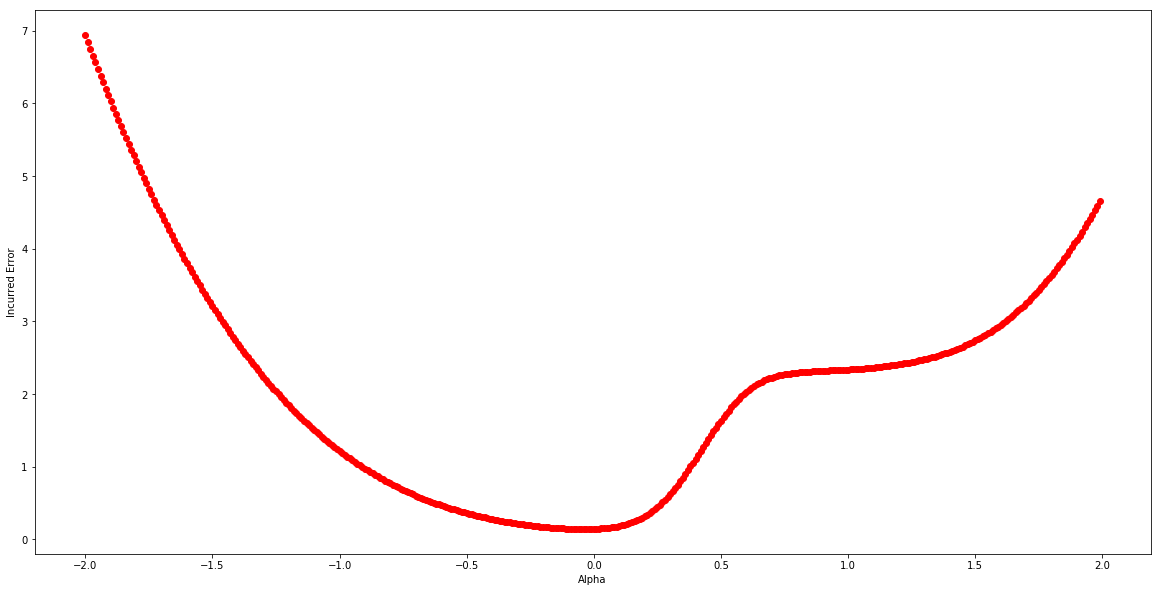

In [8]:
summary_writer = tf.summary.FileWriter("linear_interp_logs/",
                                        graph_def=sess.graph_def)
summary_op = tf.summary.merge_all()
results = []
for a in np.arange(-2, 2, 0.01):
    feed_dict = {
        x: mnist.test.images,
        y: mnist.test.labels,
        alpha: [[a]],
    }

    cost, summary_str = sess.run([cost_inter, summary_op], feed_dict=feed_dict)
    summary_writer.add_summary(summary_str, (a + 2)/0.01)
    results.append(cost)
plt.figure(figsize=(20,10))
plt.plot(np.arange(-2, 2, 0.01), results, 'ro')
plt.ylabel('Incurred Error')
plt.xlabel('Alpha')
plt.show()